## CLASIFICACIÓN DE EMOCIONES

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import string
import re
import json
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
stop_words = set(stopwords.words('english'))

%matplotlib inline

Lectura de los datasets con tweets clasificados por emociones. Cada dataset tiene tweets con una emoción concreta. Leemos los json, y los juntamos en un mismo dataset para poder entrenar nuestro modelo.

In [2]:
with open('../Data/anger.json') as json_file:
    anger = json.load(json_file)
df_anger = pd.DataFrame(anger,columns=['tweet'])
df_anger["emotion"] = "anger"

with open('../Data/fear.json') as json_file:
    fear = json.load(json_file)
df_fear = pd.DataFrame(fear,columns=['tweet'])
df_fear["emotion"] = "fear"

with open('../Data/greed.json') as json_file:
    greed = json.load(json_file)
df_greed = pd.DataFrame(greed,columns=['tweet'])
df_greed["emotion"] = "greed"

with open('../Data/hateful.json') as json_file:
    hateful = json.load(json_file)
df_hateful = pd.DataFrame(hateful,columns=['tweet'])
df_hateful["emotion"] = "hateful"

with open('../Data/joy.json') as json_file:
    joy = json.load(json_file)
df_joy = pd.DataFrame(joy,columns=['tweet'])
df_joy["emotion"] = "joy"

with open('../Data/sadness.json') as json_file:
    sadness = json.load(json_file)
df_sadness = pd.DataFrame(sadness,columns=['tweet'])
df_sadness["emotion"] = "sadness"

In [3]:
df_sadness.tweet.str.len().max()

20193

In [4]:
df = pd.concat([df_anger, df_fear, df_greed, df_hateful, df_joy, df_sadness],ignore_index=True)

In [5]:
print(f'Nº de registros de ANGER {df_anger.emotion.value_counts()}')
print(f'Nº de registros de ANGER {df_fear.emotion.value_counts()}')
print(f'Nº de registros de ANGER {df_greed.emotion.value_counts()}')
print(f'Nº de registros de ANGER {df_hateful.emotion.value_counts()}')
print(f'Nº de registros de ANGER {df_joy.emotion.value_counts()}')
print(f'Nº de registros de ANGER {df_sadness.emotion.value_counts()}')


Nº de registros de ANGER anger    3596
Name: emotion, dtype: int64
Nº de registros de ANGER fear    50053
Name: emotion, dtype: int64
Nº de registros de ANGER greed    200177
Name: emotion, dtype: int64
Nº de registros de ANGER hateful    10206
Name: emotion, dtype: int64
Nº de registros de ANGER joy    54565
Name: emotion, dtype: int64
Nº de registros de ANGER sadness    9765
Name: emotion, dtype: int64


En nuestro dataset las emociones son nuestro target. Vamos a transformarlas a variables categóricas.

In [8]:
df.emotion = pd.Categorical(df.emotion)
df.emotion.value_counts()
df['emotion'] = df.emotion.cat.codes

# TRADUCCIÓN
# 0 = anger 
# 1 = fear
# 2 = greed
# 3 = hateful
# 4 = joy
# 5 = sadness

In [9]:
df.head()

,tweet,emotion
0,@amritabithi You're gonna hate it when it is a...,0
1,RT @stauffelbaker: Everyone loves to hate #eos...,0
2,"RT @dilan_chi2012: #IfIWas a mad scientist, I'...",0
3,Bitcoin Cash Price Turns Bullish yet BCH Hate ...,0
4,I see the Tesla fanboys are angry at the idea ...,0


In [10]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [11]:
def plot_cm_(labels, predictions):
    
    con_mat = tf.math.confusion_matrix(labels, predictions).numpy()
    classes = label_index.keys()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis = 1)[:, np.newaxis], decimals = 3)

    con_mat_df = pd.DataFrame(con_mat_norm,
                         index = classes, 
                         columns = classes)

    figure = plt.figure(figsize=(3, 3))
    sns.heatmap(con_mat_df
                , annot=True
                , xticklabels=classes
                , yticklabels=classes
                #, cmap=plt.cm.Blues
                )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Distribución de clases

In [12]:
def get_list_counts(df, feature, pandas = False):
    df = df.copy(deep=True)
    x = df[feature].value_counts()
    if pandas:
        x = x.rename_axis('unique_values').reset_index(name='counts')
    return x

original label type :<class 'numpy.int8'>
label type changed to :<class 'str'>


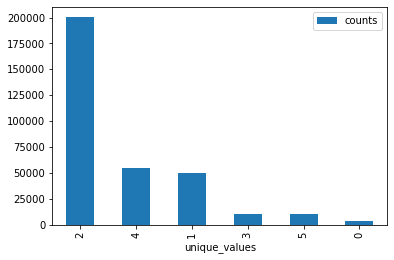

In [13]:
# change labels if not text
print('original label type :' + str(type(df.emotion[0])))
if type(df.emotion[0]) != str:
    df.emotion = df.emotion.astype(str)
    print('label type changed to :' + str(type(df.emotion[0])))
    
# plpot label distirbution
label_count = get_list_counts(df, 'emotion', pandas = True)
label_count.set_index('unique_values').plot(kind='bar')

### Cleaning Text

In [14]:
#Remove punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

#Remove Emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def text_clean(df, feature):
    df = df.copy(deep=True)
    df["tweet"] = df["tweet"].str.replace(r'\n','', case = False)
    df["tweet"] = df["tweet"].str.replace(r'\r','', case = False)
    df['tweet'] = df[feature].str.encode('ascii', 'ignore').str.decode('ascii')
    # lowering debe ser siempre lo primero de todo
    df['tweet'] = df['tweet'].str.lower()
    #Remove Links
    df['tweet'] = df['tweet'].str.replace('http\S+', '', case=False)
    
    #Remove Mentions @
    #df['tweet'] = df['tweet'].str.replace('@\S+', '', case=False)
    
    #Remove RT
    #'\bRT\b'
    df['tweet'] = df['tweet'].str.replace(r'\bRT\b', '', case = True)
    df['tweet'] = df['tweet'].str.replace(r'\brt\b', '', case = True)
    df['tweet'] = df['tweet'].apply(lambda x: remove_punct(x))
    df['tweet'] = df['tweet'].apply(lambda x: remove_emoji(x))
    #Para que tsla y Tesla no cuenten como dos palabras (muy frecuente), igualamos a tesla.
    df['tweet'] = df['tweet'].str.replace(r'\btsla\b', '', case = True)
    df['tweet'] = df['tweet'].str.replace(r'\tesla\b', '', case = True)

    return df['tweet']

df['tweet'] = text_clean(df, 'tweet')

In [15]:
pat1 = r'http[^ ]+'
pat2 = r'www.[^ ]+'
pat3 = '[^a-zA-Z]+'
pat = r'|'.join((pat1, pat2, pat3))

def get_clean_text(text):
    text = text.lower()
    text = re.sub(pat, ' ', text)
    text = [w for w in tok.tokenize(text) if not w in stop_words]
    text = [w for w in text if len(w)>1]
    text = (' '.join(text)).strip()
    return text
df['tweet'] = [get_clean_text(t) for t in df['tweet']]

In [16]:
df.head()

,tweet,emotion
0,amritabithi youre gonna hate token running for...,0
1,stauffelbaker everyone loves hate eosio keeps ...,0
2,dilanchi ifiwas mad scientist ill make time ma...,0
3,bitcoin cash price turns bullish yet bch hate ...,0
4,see tesla fanboys angry idea thieving eu could...,0


### Parameters

Calculamos el número de palabras únicas en nuestro corpus tras haberlo limpiado.

In [17]:
corpus = []

for i in range(0, len(df["tweet"])):
    corpus.append(df["tweet"][i])

In [18]:
def wordlist(lista):
    return re.sub("[^\w]", " ",  lista).split()

wordlista = []
for i in range(0, len(corpus)):
    wordlista.append(wordlist(corpus[i]))
    
flat_list = [item for sublist in wordlista for item in sublist]

In [19]:
vocab_size = len(Counter(flat_list).keys())

print(vocab_size)

176661


Reduzco el número de palabras quedándome con las más frecuentes.

In [20]:
from collections import Counter
Counter(" ".join(df["tweet"]).split()).most_common(100)

[('cryptocurrency', 74935),
 ('bitcoin', 69520),
 ('blockchain', 64691),
 ('great', 50108),
 ('crypto', 41725),
 ('big', 29118),
 ('btc', 26245),
 ('join', 23689),
 ('investment', 22174),
 ('selling', 21800),
 ('using', 20265),
 ('project', 19795),
 ('high', 19133),
 ('code', 17462),
 ('stuff', 17245),
 ('earning', 16938),
 ('extra', 16874),
 ('listia', 16606),
 ('xnk', 16605),
 ('price', 16580),
 ('new', 16279),
 ('market', 14300),
 ('info', 14201),
 ('bullish', 13666),
 ('ethereum', 13332),
 ('like', 11553),
 ('amp', 11198),
 ('money', 11102),
 ('news', 10785),
 ('one', 10614),
 ('happy', 10485),
 ('profit', 10441),
 ('get', 10120),
 ('see', 10035),
 ('people', 9836),
 ('time', 9466),
 ('trading', 9207),
 ('stock', 9141),
 ('exchange', 9138),
 ('good', 8992),
 ('team', 8728),
 ('xrp', 8170),
 ('us', 8093),
 ('back', 7974),
 ('cash', 7849),
 ('know', 7614),
 ('read', 7532),
 ('dont', 7456),
 ('eth', 7411),
 ('data', 7289),
 ('make', 7221),
 ('would', 6835),
 ('im', 6788),
 ('use', 671

Tras analizar las 100 palabras más frecuentes, voy a eliminar las palabras que estén altamente relacionadas con la temática "criptomoneda", dado que voy a hacer predicciones sobre el dataset de tesla, y no quiero que influyan en la predicción.

In [21]:
crypto_voc = ["cryptocurrency", "bitcoin", "blockchain", "crypto", "btc", "listia", "xnk", "ethereum", "xrp", "eth",
              "ico", "binance", "litecoin", "coin"
             ]

In [22]:
pat = r'\b(?:{})\b'.format('|'.join(crypto_voc))
df['tweet'] = df['tweet'].str.replace(pat, '')

In [23]:
Counter(" ".join(df["tweet"]).split()).most_common(100)

[('great', 50108),
 ('big', 29118),
 ('join', 23689),
 ('investment', 22174),
 ('selling', 21800),
 ('using', 20265),
 ('project', 19795),
 ('high', 19133),
 ('code', 17462),
 ('stuff', 17245),
 ('earning', 16938),
 ('extra', 16874),
 ('price', 16580),
 ('new', 16279),
 ('market', 14300),
 ('info', 14201),
 ('bullish', 13666),
 ('like', 11553),
 ('amp', 11198),
 ('money', 11102),
 ('news', 10785),
 ('one', 10614),
 ('happy', 10485),
 ('profit', 10441),
 ('get', 10120),
 ('see', 10035),
 ('people', 9836),
 ('time', 9466),
 ('trading', 9207),
 ('stock', 9141),
 ('exchange', 9138),
 ('good', 8992),
 ('team', 8728),
 ('us', 8093),
 ('back', 7974),
 ('cash', 7849),
 ('know', 7614),
 ('read', 7532),
 ('dont', 7456),
 ('data', 7289),
 ('make', 7221),
 ('would', 6835),
 ('im', 6788),
 ('use', 6710),
 ('low', 6685),
 ('short', 6604),
 ('pump', 6572),
 ('platform', 6441),
 ('first', 6083),
 ('technology', 6000),
 ('buy', 5907),
 ('via', 5885),
 ('future', 5866),
 ('think', 5861),
 ('learn', 5853

In [24]:
contador = Counter(" ".join(df["tweet"]).split()).elements

Me voy a quedar con las 15.000 palabras más frecuentes

In [25]:
vocab_size = 15000
contador = Counter(" ".join(df["tweet"]).split()).most_common()[vocab_size:]

In [26]:
tail_words = []
for i in range(0, len(contador)):
    tail_words.append(contador[i][0])
    
pat = r'\b(?:{})\b'.format('|'.join(tail_words))
df['tweet'] = df['tweet'].str.replace(pat, '')

In [27]:
df.head()

,tweet,emotion
0,youre gonna hate token running fork cash,0
1,everyone loves hate eosio keeps ahead fud li...,0
2,mad scientist ill make time machine amp trav...,0
3,cash price turns bullish yet bch hate wont,0
4,see tesla angry idea eu could fine failing ...,0


In [28]:
num_epochs = 6
#vocab_size = 15000  Definido antes
embedding_dim = 200
#max_length = 20 # tokens
num_convolution = 5
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # unseen tokens
training_portion = 0.6
test_proportion = 0.3

### Split train test

In [29]:
df, df_test = np.split(df.sample(frac=1).reset_index(drop=True), [int((1-test_proportion)*len(df))])

print(df.shape)
print(df_test.shape)

(229853, 2)
(98509, 2)


In [30]:
y = df['emotion'].to_list()
x = df['tweet'].to_list()

In [31]:
label_distinct = len(set(y))
label_distinct

6

In [32]:
train_size = int(len(y) * training_portion)

x_train = x[0: train_size]
y_train = y[0: train_size]

x_val = x[train_size:]
y_val = y[train_size:]

print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

137911
137911
91942
91942


In [33]:
# Create dictionary word_index. Tokenizer takens vocab_size most common words. oov_token is to put a special value in 
# when an unseen word is encountered. This means I want "OOV" in bracket to be used to for words that are not in the 
#word index. "fit_on_text" will go through all the text and create dictionary.
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y_train)
label_index = label_tokenizer.word_index
# Tokenizer indexes from 1 to p, where p is number of categories.
# Is useful to substract 1 in order to start from 0 instead of 1. This way the final Dense layer doesnt need a dummy.
for k in label_index:
    label_index[k] -= 1

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [34]:
dict(list(word_index.items())[0:5])

{'<OOV>': 1, 'great': 2, 'big': 3, 'join': 4, 'investment': 5}

In [35]:
# tokenize
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)

y_train_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
y_val_seq = np.array(label_tokenizer.texts_to_sequences(y_val))

In [36]:
label_index

{'2': 0, '4': 1, '1': 2, '3': 3, '5': 4, '0': 5}

### Pad

In [37]:
df["lon"] = df["tweet"].apply(lambda x: len(x.split()))

In [38]:
df.sort_values("lon", ascending = False).head()

,tweet,emotion,lon
131797,primary purpose document provide transparency...,0,1447
51249,primary purpose document provide transparency...,2,1447
44756,primary purpose document provide transparency...,5,1447
163942,primary purpose document provide transparency...,3,1447
16041,want ive written im developer serious program...,1,1255


In [39]:
df.reset_index(inplace = True)

In [40]:
df.head()

,index,tweet,emotion,lon
0,0,earning selling stuff join using code dqjsmj...,1,8
1,1,verified months,2,2
2,2,investment assets managers offers opportunity...,2,9
3,3,earning selling stuff join using code bkbfsr...,1,8
4,4,grand theft state cryptocurrencystealing malw...,3,7


Quiero ver la distribución de longitud de los tweets para ver dónde poner el límite de máxima longitud

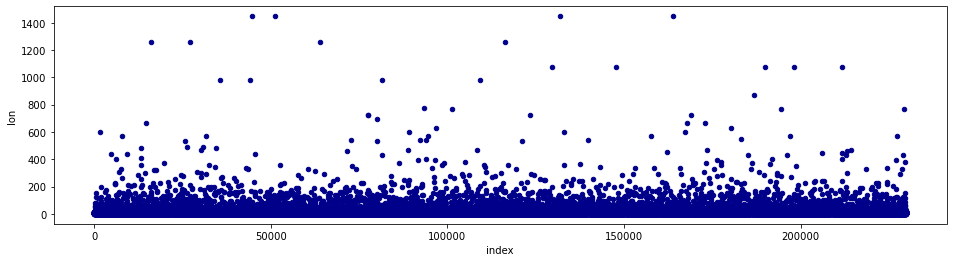

In [41]:
ax1 = df.plot.scatter(x='index',
                      y='lon',
                      c='DarkBlue',
                      figsize=(16, 4))

Probamos poniendo el límite en 120

In [42]:
max_length = 120

In [43]:
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [44]:
print(x_train[0]) # original text
print(x_train_seq[0]) # tokenized text
print(x_train_pad[0]) # padd sequence

print(y_train[0]) # original label

earning  selling stuff  join using code dqjsmj extra 
[13, 6, 11, 4, 8, 10, 3228, 14]
[  13    6   11    4    8   10 3228   14    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
1


### Sequence decoder

In [45]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_text(text):
    print(text)
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [46]:
pre_trained_embedding = "../../Glove/glove.twitter.27B.200d.txt"

In [47]:
# transform embedding using tokenized indexes. This is, transfowm the embedded word into same token your data has

embeddings_index = {}

f = open(pre_trained_embedding, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    # put token in the corresponding row (indexing)
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()

excluded_embeddings = []
embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else: excluded_embeddings.append(word)

Dado que el Dataset está altamente desbalanceado, aplico SMOTE para mejorar la predicción sobre las clases minoritarias.

In [48]:
from imblearn.over_sampling import SMOTE
smote = SMOTE("minority")

X, y = smote.fit_sample(x_train_pad, y_train_seq)

Using TensorFlow backend.


In [49]:
print(f'Longitud del train antes de aplicar SMOTE: {len(x_train_pad)}')
print(f'Longitud del train después de aplicar SMOTE: {len(X)}')

Longitud del train antes de aplicar SMOTE: 137911
Longitud del train después de aplicar SMOTE: 220733


### Modelo 1

In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1 #input dim
                               , embedding_dim #out dim
                               , weights=[embedding_matrix] #his is actually the pretrained embedding
                               , input_length=max_length 
                               , trainable=False) # Trainable = True when embedding from scratch

    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    , tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim))   
    , tf.keras.layers.Dense(embedding_dim, activation='relu')
    , tf.keras.layers.Dense(label_distinct, activation='softmax')

])
model.compile(loss='sparse_categorical_crossentropy'
              , optimizer='adam'
              , metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 200)          3000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 400)               641600    
_________________________________________________________________
dense (Dense)                (None, 200)               80200     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1206      
Total params: 3,723,006
Trainable params: 723,006
Non-trainable params: 3,000,000
_________________________________________________________________


In [51]:
history = model.fit(X, y
                    , epochs=num_epochs
                    , validation_data=(x_val_pad, y_val_seq)
                    , verbose=1)

Train on 220733 samples, validate on 91942 samples
Epoch 1/6
220733/220733 [==============================] - 7783s 35ms/sample - loss: 0.3858 - accuracy: 0.8554 - val_loss: 0.3350 - val_accuracy: 0.8758
Epoch 2/6
220733/220733 [==============================] - 7344s 33ms/sample - loss: 0.2303 - accuracy: 0.9139 - val_loss: 0.2514 - val_accuracy: 0.9069
Epoch 3/6
220733/220733 [==============================] - 7308s 33ms/sample - loss: 0.1750 - accuracy: 0.9336 - val_loss: 0.2371 - val_accuracy: 0.9120
Epoch 4/6
220733/220733 [==============================] - 7254s 33ms/sample - loss: 0.1348 - accuracy: 0.9466 - val_loss: 0.3127 - val_accuracy: 0.8919
Epoch 5/6
220733/220733 [==============================] - 7142s 32ms/sample - loss: 0.1075 - accuracy: 0.9556 - val_loss: 0.3009 - val_accuracy: 0.9014
Epoch 6/6
220733/220733 [==============================] - 8972s 41ms/sample - loss: 0.0911 - accuracy: 0.9606 - val_loss: 0.2793 - val_accuracy: 0.9120


## Validate

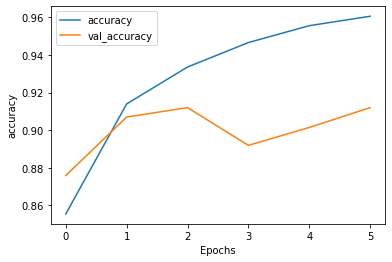

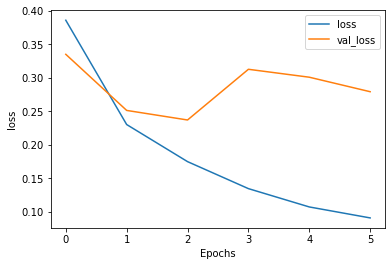

In [52]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [53]:
results = model.evaluate(x_val_pad, y_val_seq)

91942/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [54]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

print(acc[-1])
print(val_acc[-1])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
0.9606312
0.91196626


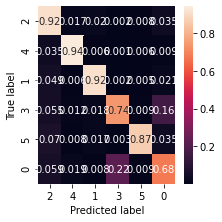

In [55]:
y_pred = model.predict_classes(x_val_pad)

plot_cm_(labels = y_val_seq, predictions = y_pred)

## Test

In [56]:
df_test.reset_index(drop=True, inplace=True)

df_test['tweet'] = text_clean(df_test, 'tweet')
df_test['tweet'] = [get_clean_text(t) for t in df_test['tweet']]

# change labels if not text
print('original label type :' + str(type(df_test.emotion[0])))
if type(df_test.emotion[0]) != str:
    df_test.emotion = df_test.emotion.astype(str)
    print('label type changed to :' + str(type(df_test.emotion[0])))
    
y_test = df_test['emotion'].to_list()
x_test = df_test['tweet'].to_list()

KeyboardInterrupt: 

In [ ]:
x_test_seq  = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

y_test_seq = np.array(label_tokenizer.texts_to_sequences(y_test))

In [ ]:
y_test_pred = model.predict_classes(x_test_pad)

plot_cm_(labels = y_test_seq, predictions = y_test_pred)

### Predicciones sobre tweets de Tesla

In [84]:
df_tesla = pd.read_csv('../Data/df_with_mod1.csv', encoding='utf-8-sig') 

df_tesla.reset_index(inplace = True)

In [85]:
df_tesla.head()

,index,Unnamed: 0,timing_concat,tweet_count,length,n_mentions,elon_mentions,tesla_mentions,link,RT,open,resumen,CLASE,label_predict
0,0,0,20190515153,155,113.402685,304,12,41,90,155,229.238,um heard help gui gooey well arent ball ba...,0,0.091300
1,1,1,20190515154,207,122.841026,300,15,41,148,207,226.898,gameev ca realli wow it amaz bid b love b...,0,0.109234
2,2,2,20190515155,198,121.530928,267,14,39,130,198,226.927,call curiou sell sell uber buy gold spot a...,1,0.934368
3,3,3,20190515160,197,117.746032,218,15,37,132,197,227.538,fix paint problem chenl realli exactli me...,1,0.901860
4,4,4,20190515161,177,119.710059,257,21,28,109,177,227.597,beauti p good threadtslaq not rass must r...,1,0.918982


In [86]:
df_tesla.drop(["index", "Unnamed: 0"], axis = 1, inplace = True)

In [87]:
df_tesla["emotion"] = ""

y_tesla = df_tesla['emotion'].to_list()
x_tesla = df_tesla['resumen'].to_list()

In [88]:
x_tesla_seq  = tokenizer.texts_to_sequences(x_tesla)
x_tesla_pad = pad_sequences(x_tesla_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

y_tesla_seq = np.array(label_tokenizer.texts_to_sequences(y_tesla))

In [89]:
y_tesla_pred = model.predict_classes(x_tesla_pad)

In [90]:
y_tesla_pred

array([5, 5, 5, ..., 5, 5, 5], dtype=int64)

In [91]:
dataframe=pd.DataFrame(y_tesla_pred, columns=['Predictions'])
dataframe['Predictions'].value_counts()

5    2248
0     416
1     156
2      57
3      45
4      39
Name: Predictions, dtype: int64

In [92]:
dataframe.head()

,Predictions
0,5
1,5
2,5
3,5
4,5


In [93]:
df_tw_em = pd.concat([df_tesla, dataframe], axis = 1, ignore_index = True)

In [94]:
df_tw_em.drop([8, 12], axis = 1, inplace = True)

In [95]:
df_result = df_tw_em.copy(deep = True)

In [96]:
df_result.head()

,0,1,2,3,4,5,6,7,9,10,11,13
0,20190515153,155,113.402685,304,12,41,90,155,um heard help gui gooey well arent ball ba...,0,0.091300,5
1,20190515154,207,122.841026,300,15,41,148,207,gameev ca realli wow it amaz bid b love b...,0,0.109234,5
2,20190515155,198,121.530928,267,14,39,130,198,call curiou sell sell uber buy gold spot a...,1,0.934368,5
3,20190515160,197,117.746032,218,15,37,132,197,fix paint problem chenl realli exactli me...,1,0.901860,5
4,20190515161,177,119.710059,257,21,28,109,177,beauti p good threadtslaq not rass must r...,1,0.918982,5


In [97]:
df_result.columns = ["timing_concat", "tweet_count", "length", "n_mentions", "elon_mentions", "tesla_mentions",
                    "link", "RT", "resumen", "CLASE", "prob_mod1", "emotions"]

In [98]:
df_result.head()

,timing_concat,tweet_count,length,n_mentions,elon_mentions,tesla_mentions,link,RT,resumen,CLASE,prob_mod1,emotions
0,20190515153,155,113.402685,304,12,41,90,155,um heard help gui gooey well arent ball ba...,0,0.091300,5
1,20190515154,207,122.841026,300,15,41,148,207,gameev ca realli wow it amaz bid b love b...,0,0.109234,5
2,20190515155,198,121.530928,267,14,39,130,198,call curiou sell sell uber buy gold spot a...,1,0.934368,5
3,20190515160,197,117.746032,218,15,37,132,197,fix paint problem chenl realli exactli me...,1,0.901860,5
4,20190515161,177,119.710059,257,21,28,109,177,beauti p good threadtslaq not rass must r...,1,0.918982,5


In [99]:
df_result.to_csv("..\Data\df_with_mod1 and emotion.csv")

In [76]:
df_tw_em.head()

,0,1,2,3,4,5,6,7,9,10,11,13
0,20190515153,155,113.402685,304,12,41,90,155,um heard help gui gooey well arent ball ba...,0,0.732864,5
1,20190515154,207,122.841026,300,15,41,148,207,gameev ca realli wow it amaz bid b love b...,0,0.454668,5
2,20190515155,198,121.530928,267,14,39,130,198,call curiou sell sell uber buy gold spot a...,1,0.402249,5
3,20190515160,197,117.746032,218,15,37,132,197,fix paint problem chenl realli exactli me...,1,0.645906,5
4,20190515161,177,119.710059,257,21,28,109,177,beauti p good threadtslaq not rass must r...,1,0.443768,5
